In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

import unicodedata
import sys

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk import WordNetLemmatizer, pos_tag
from nltk.util import ngrams

from sklearn.svm import OneClassSVM 
from sklearn.metrics import log_loss, make_scorer, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer


from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


**EDA**

In [45]:
#makeup alley
ma = pd.read_csv('makeup_alley_data.csv')

In [51]:
#2 sephora datasets
s1 = pd.read_csv('Sephora_review.csv')
s2 = pd.read_csv('sephora_review_ordinary.csv')

In [52]:
s1.head()

,product_id,review_title,review_text,rating,age_range,skin_type,skin_tone,eye_color,reviewer_username,tags,review_id
0,P38217,Worth the money,"Sometimes I stray from this cleanser, but I al...",5,NaN,normal,light,NaN,katechatte,"{foamy,exfoliating}",6611717f-2636-4756-bf36-66c81cc267a7
1,P38217,Great,I am a 41 year old African American woman with...,5,NaN,combination,deep,NaN,snook41,{foamy},e7d3307e-02ff-45a1-8fc3-6bd628bedd86
2,P38217,Great Product,I'm really enjoying this product. Received a s...,5,NaN,combination,olive,NaN,wahinewarrior,"{foamy,milky,exfoliating}",4188d728-fde6-4d06-984e-164cca2b8781
3,P38217,"Nice, but not great for combination skin","I tried this cleanser at a friends house, and ...",3,NaN,combination,fair,NaN,jenlines22,"{hydrating,creamy}",248c904c-6e30-4929-8228-87b03ad7a921
4,P38217,great moisturizer,leaves the skin feeling fresh and revived... j...,5,NaN,dry,light,NaN,jessea,{exfoliating},654bdb99-9371-4440-a540-0dd2a73da339


In [54]:
s1 = s1[['review_text', 'rating']]

In [55]:
s1

,review_text,rating
0,"Sometimes I stray from this cleanser, but I al...",5
1,I am a 41 year old African American woman with...,5
2,I'm really enjoying this product. Received a s...,5
3,"I tried this cleanser at a friends house, and ...",3
4,leaves the skin feeling fresh and revived... j...,5
...,...,...
995,"Only have to use a pea size amount, foams and ...",5
996,This is by far the best cleansing foam I have ...,5
997,I have a very hard time finding facial cleaner...,5
998,I got a sample from sephora this product is a ...,1


In [62]:
s2 = s2[['r_review', 'r_star']]
s2 = s2.rename(columns={'r_review': 'review_text', 'r_star':'rating'})

In [63]:
#combine 2 dataset
s = pd.concat([s1,s2])

In [67]:
s = s.rename(columns={'review_text':'Review','rating':'Rating'})

In [68]:
s.head()

,Review,Rating
0,"Sometimes I stray from this cleanser, but I al...",5
1,I am a 41 year old African American woman with...,5
2,I'm really enjoying this product. Received a s...,5
3,"I tried this cleanser at a friends house, and ...",3
4,leaves the skin feeling fresh and revived... j...,5


In [65]:
ma.head()

,Product,Brand,Review,Rating,User
0,Facial Moisturizing Lotion - AM SPF 30CeraVe,CeraVe,Good as an all-year round SPF with some moistu...,4.0,subhuman85
1,Facial Moisturizing Lotion - AM SPF 30CeraVe,CeraVe,I have the spf 25 version but I'm pretty sure ...,4.0,MyrtoSpy
2,Facial Moisturizing Lotion - AM SPF 30CeraVe,CeraVe,"Ok, so this moisturizer doesn't work well unde...",4.0,betteefelon
3,Facial Moisturizing Lotion - AM SPF 30CeraVe,CeraVe,There’s a knack to applying this cream without...,4.0,Acass2020
4,Facial Moisturizing Lotion - AM SPF 30CeraVe,CeraVe,This moisturizes well but breaks me out everyt...,1.0,Nikki02788


In [75]:
s.describe()

,Rating
count,2209.000000
mean,4.378904
std,1.166380
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


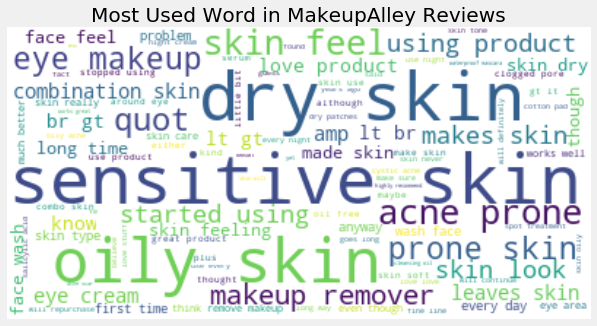

In [76]:
#review text not cleaned
text = " ".join(review for review in ma.Review)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Most Used Word in MakeupAlley Reviews')
plt.axis("off")
plt.show()

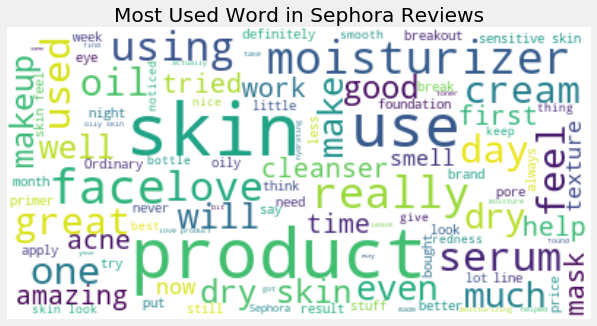

In [73]:
#review text not cleaned
text = " ".join(review for review in s.Review)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Most Used Word in Sephora Reviews')
plt.axis("off")
plt.show()

In [ ]:
ma_review_len = [len(ma.Review[i]) for i in range(len(ma))]
ma.Review.mean()

s_review_len = [len(s.Review[i]) for i in range(len(s))]
s.Review.mean()

In [ ]:
plt.figure(figsize=(10,5))
plt.boxplot(ma_review_len, showfliers = False)
plt.boxplot(s_review_len, showfliers = False)
plt.legend()

**Clean Text**

In [ ]:
import unicodedata
import sys
def cleanText(wordSeries):
        tbl = dict.fromkeys(i for i in range(sys.maxunicode)
                            if unicodedata.category(chr(i)).startswith('P'))
        def remove_accents(input_str):
            nfkd_form = unicodedata.normalize('NFKD', input_str)
            only_ascii = nfkd_form.encode('ASCII', 'ignore')
            return only_ascii.decode()
        def remove_punctuation(text):
            return text.translate(tbl)
        wordSeries = wordSeries.apply(lambda x: remove_punctuation(x))#remove punctuation
        wordSeries = wordSeries.apply(lambda x: ''.join([i for i in x if not i.isdigit()]))#remove digits
        wordSeries = wordSeries.apply(lambda x: x.lower())#lower cases
        wordSeries = wordSeries.apply(lambda x: x.replace('<br >', ' '))#remove html
        wordSeries = wordSeries.apply(lambda x: x.replace('<br>', ' '))#remove html
        wordSeries = wordSeries.apply(lambda x: x.replace('\n', ' '))#remove html
        wordSeries = wordSeries.apply(lambda x: x.replace('\n\n', ' '))
        wordSeries = wordSeries.apply(lambda x: x.replace('$', ' '))
        wordSeries = wordSeries.apply(lambda x: x.replace('>', ' '))
        wordSeries = wordSeries.apply(lambda x: remove_accents(x))
        wordSeries = wordSeries.apply(lambda x: x.replace('`', ''))#remove extra punctuation
        # wordSeries = wordSeries.apply(lambda x: x.replace(' id ', ' '))
        return wordSeries
    
#example df name test, column name text --> cleanText(test.text)

**Bag of Word**

**One Class Classification Model**

In [41]:
def split(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y)

In [39]:
#GridSearch
def BestEstimator(X_train, X_test, y_train, y_test):
    model = OneClassSVM()

    #default Kernel is 'rbf'

    gammas = np.arange(0,1,0.001)
    nus = np.arange(0,1.1,0.1)
    shrinkings = [True, False]
    parameters = {'gamma': gammas,
                  'nu': nus,
                  'shrinkings': shrinkings}

    scorer = make_scorer(log_loss,
                         greater_is_better=False,
                         needs_proba=True)

    clf = GridSearchCV(model,
                       parameters,
                       cv=10,
                       scoring=scorer)

    clf.fit(X_train, y_train)

    print(f"log loss = {-clf.score(X_test, y_test)}") 
    print(f"accuracy = {(clf.predict(X_test) == y_test).mean()}")
    print(clf.best_estimator_)
    print(clf.best_params_)
    print(clf.best_score_ )
    return clf.best_estimator_

In [42]:
#use parameters got from gridsearch to run a model
def confusion_matrix(BestEstimator, X_test, y_test):
    model = BestEstimator
    y_pred = model.fit.predict(X_test)
    return confusion_matrix(y_test, y_pred) 